New Stack ensemble with LR as meta Learner

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# --------------------------
# 1. Load Data (Merge UNSW-NB15 files if multiple)
# --------------------------
train_file = "UNSW_NB15_training-set.csv"
test_file = "UNSW_NB15_testing-set.csv"

train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

# --------------------------
# 2. Preprocessing
# --------------------------

# Separate features & labels
X = df.drop(columns=["label", "attack_cat"])  # "label" is target, attack_cat is extra
y = df["label"]

# Encode categorical columns
cat_cols = X.select_dtypes(include=["object"]).columns
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# Standardize numeric features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Train-test split (stratified to balance classes)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --------------------------
# 3. Base Learners
# --------------------------
base_learners = [
    ("rf", RandomForestClassifier(n_estimators=200, max_depth=20,
                                  n_jobs=-1, random_state=42)),

    ("lgbm", LGBMClassifier(n_estimators=300, learning_rate=0.05,
                            random_state=42, n_jobs=-1)),

    ("cat", CatBoostClassifier(iterations=300, depth=8,
                               learning_rate=0.05, verbose=0, random_seed=42)),

    ("xgb", XGBClassifier(n_estimators=300, learning_rate=0.05,
                          max_depth=8, subsample=0.8,
                          colsample_bytree=0.8, use_label_encoder=False,
                          eval_metric="logloss", n_jobs=-1, random_state=42))
]

# --------------------------
# 4. Meta Learner
# --------------------------
meta_learner = LogisticRegression(max_iter=1000, random_state=42)

stack_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,
    n_jobs=-1
)

# --------------------------
# 5. Training
# --------------------------
print("Training Stacking Ensemble...")
stack_model.fit(X_train, y_train)

# --------------------------
# 6. Evaluation
# --------------------------
y_pred = stack_model.predict(X_test)

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Training Stacking Ensemble...


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99     18600
           1       0.99      0.99      0.99     32935

    accuracy                           0.99     51535
   macro avg       0.99      0.99      0.99     51535
weighted avg       0.99      0.99      0.99     51535

Accuracy: 0.9895216842922285


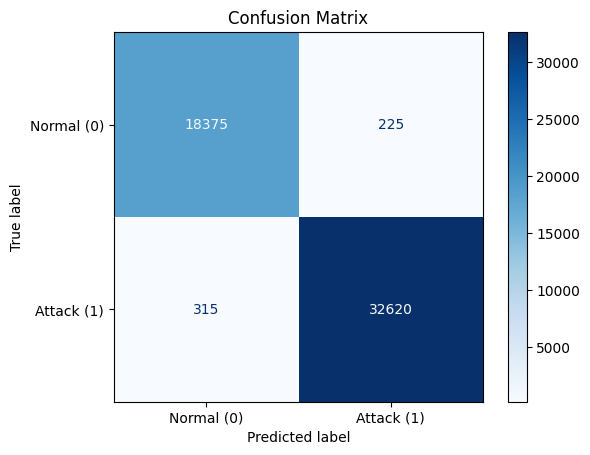

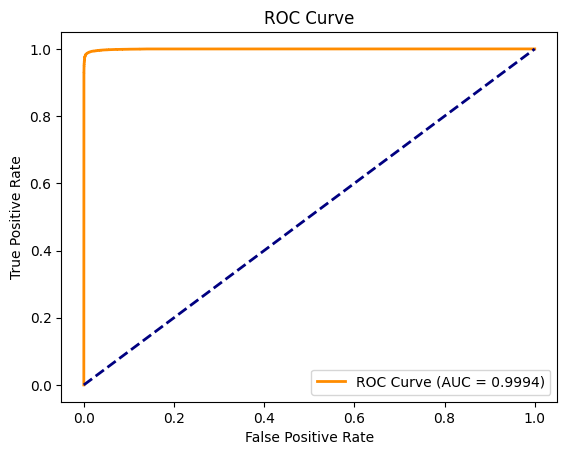

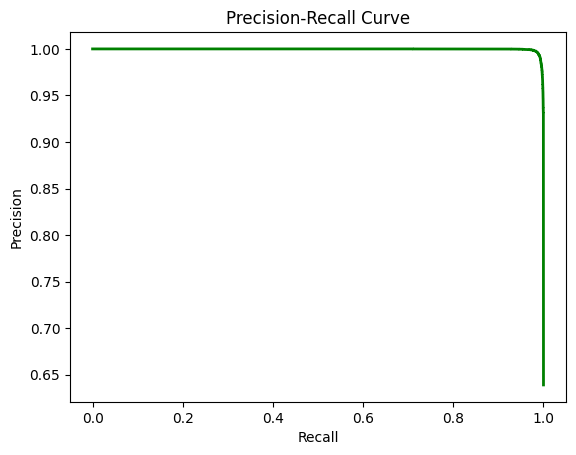

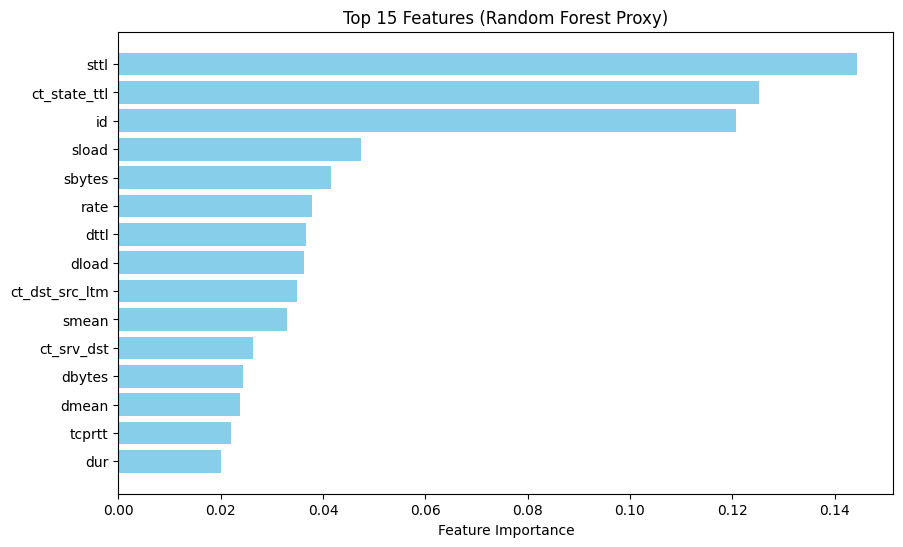

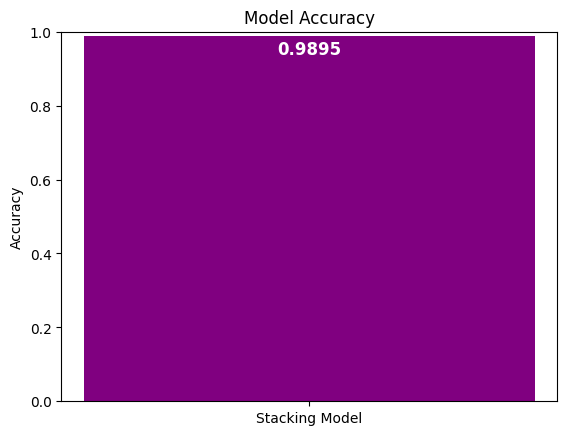

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve

# --------------------------
# 1. Confusion Matrix
# --------------------------
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal (0)", "Attack (1)"])
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix")
plt.show()

# --------------------------
# 2. ROC Curve
# --------------------------
y_proba = stack_model.predict_proba(X_test)[:, 1]  # probability of class 1
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# --------------------------
# 3. Precision-Recall Curve
# --------------------------
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure()
plt.plot(recall, precision, color="green", lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

# --------------------------
# 4. Feature Importance (Random Forest as proxy)
# --------------------------
rf = RandomForestClassifier(n_estimators=200, max_depth=20, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
indices = np.argsort(importances)[-15:]  # top 15 features

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align="center", color="skyblue")
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel("Feature Importance")
plt.title("Top 15 Features (Random Forest Proxy)")
plt.show()

# --------------------------
# 5. Accuracy Bar Chart
# --------------------------
acc = accuracy_score(y_test, y_pred)

plt.figure()
plt.bar(["Stacking Model"], [acc], color="purple")
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.text(0, acc - 0.05, f"{acc:.4f}", ha="center", fontsize=12, color="white", fontweight="bold")
plt.show()


New Stack ensemble with XGBoost as meta Learner

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# -------------------------------
# Step 1: Load Data
# -------------------------------
train = pd.read_csv("UNSW_NB15_training-set.csv")
test = pd.read_csv("UNSW_NB15_testing-set.csv")

df = pd.concat([train, test], axis=0).reset_index(drop=True)

# -------------------------------
# Step 2: Drop leakage/ID columns
# -------------------------------
drop_cols = ['id', 'attack_cat']   # attack_cat is derived from label → leakage
df = df.drop(columns=drop_cols)

# -------------------------------
# Step 3: Encode categoricals
# -------------------------------
cat_cols = ['proto', 'service', 'state']
le = {}
for col in cat_cols:
    le[col] = LabelEncoder()
    df[col] = le[col].fit_transform(df[col].astype(str))

# -------------------------------
# Step 4: Features & Target
# -------------------------------
X = df.drop(columns=['label'])
y = df['label']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# -------------------------------
# Step 5: Define Base Learners
# -------------------------------
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=20, n_jobs=-1, random_state=42)),
    ('lgbm', LGBMClassifier(n_estimators=300, learning_rate=0.05, random_state=42)),
    ('cat', CatBoostClassifier(iterations=200, learning_rate=0.05, depth=8, verbose=0, random_state=42)),
    ('lr', LogisticRegression(max_iter=2000, n_jobs=-1))
]

# -------------------------------
# Step 6: Meta Learner
# -------------------------------
meta_learner = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

stack_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,
    n_jobs=-1
)

# -------------------------------
# Step 7: Train & Evaluate
# -------------------------------
stack_model.fit(X_train, y_train)
y_pred = stack_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Accuracy: 0.9511982148054721
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     18600
           1       0.97      0.96      0.96     32935

    accuracy                           0.95     51535
   macro avg       0.95      0.95      0.95     51535
weighted avg       0.95      0.95      0.95     51535



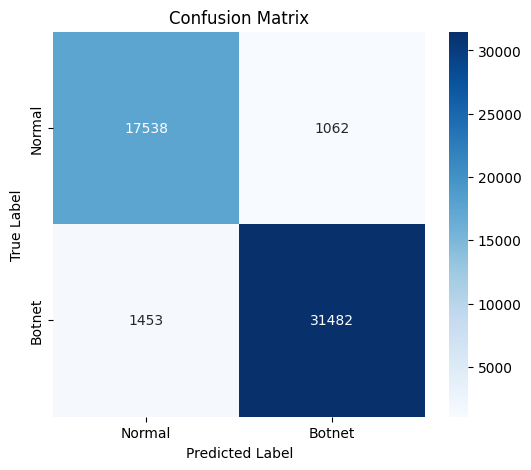

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


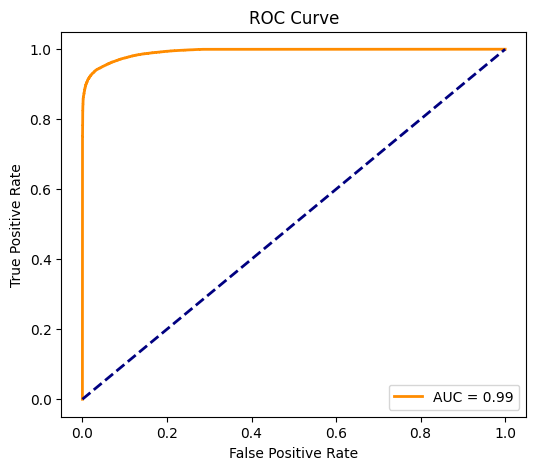

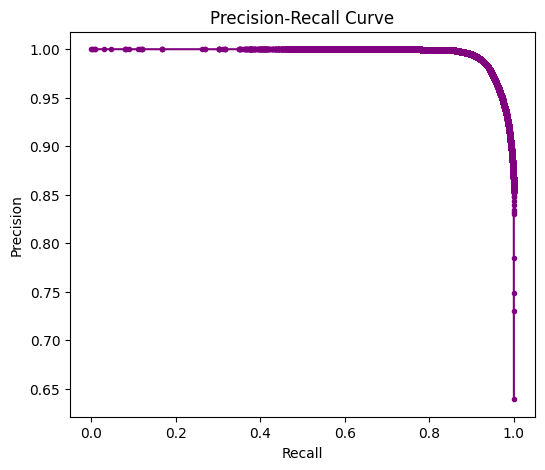

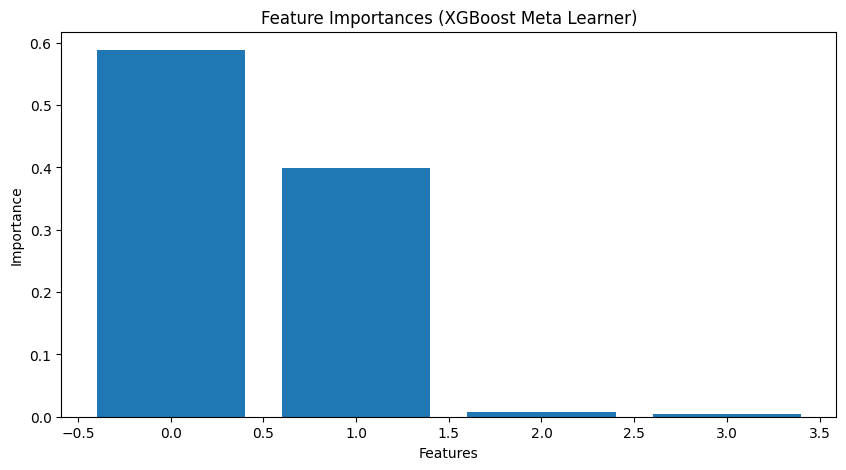

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import cross_val_score

# -------------------------------
# 1. Confusion Matrix
# -------------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Botnet'],
            yticklabels=['Normal', 'Botnet'])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# -------------------------------
# 2. ROC Curve
# -------------------------------
y_proba = stack_model.predict_proba(X_test)[:,1]  # Probabilities for class=1 (Botnet)
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1], color='navy', lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# -------------------------------
# 3. Precision-Recall Curve
# -------------------------------
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(recall, precision, marker='.', color='purple')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

# -------------------------------
# 4. Feature Importance (from meta learner XGB)
# -------------------------------
xgb = stack_model.final_estimator_
importances = xgb.feature_importances_

plt.figure(figsize=(10,5))
plt.bar(range(len(importances)), importances)
plt.title("Feature Importances (XGBoost Meta Learner)")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

